In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
df = pd.read_csv('/content/reverse_returns_dataset.csv')

In [11]:
df.head()

,return_id,customer_lat,customer_lon,product_category,product_weight,return_reason,warehouse_id
0,R0000,18.861663,73.368855,Beauty,3.36,Wrong Item,WH1
1,R0001,35.570715,83.715127,Home,0.72,Other,WH5
2,R0002,29.227824,93.315429,Beauty,3.26,Other,WH2
3,R0003,25.361096,89.234522,Apparel,2.59,Other,WH4
4,R0004,12.524541,91.390273,Apparel,2.15,Changed Mind,WH2


In [12]:
df.isnull().sum()

,0
return_id,0
customer_lat,0
customer_lon,0
product_category,0
product_weight,0
return_reason,0
warehouse_id,0


No Null Values

In [13]:
df.dropna(subset=['customer_lat' , 'customer_lon' , 'return_reason' , 'product_category'],inplace=True)

In [14]:
np.random.seed(42)
df['product_value'] = np.random.randint(50 ,500,size=len(df))

In [15]:
resale_score_map = {
    'Defective': 0.4,        # Low resale potential
    'Wrong Item': 0.85,      # Can be restocked
    'Changed Mind': 0.95,    # Very high resale potential
    'Size Issue': 0.9,       # Resellable
    'Other': 0.7             # Medium
}

In [17]:
df['resale_score'] = df['return_reason'].map(resale_score_map).fillna(0.8)

In [18]:
df.tail()

,return_id,customer_lat,customer_lon,product_category,product_weight,return_reason,warehouse_id,product_value,resale_score
995,R0995,10.655880,87.051700,Home,2.89,Size Issue,WH3,79,0.90
996,R0996,34.602094,95.741824,Books,4.72,Size Issue,WH4,296,0.90
997,R0997,11.967740,69.999782,Apparel,0.60,Defective,WH2,155,0.40
998,R0998,35.556883,69.654587,Home,1.42,Other,WH3,100,0.70
999,R0999,20.934167,76.183425,Beauty,3.94,Wrong Item,WH1,130,0.85


In [19]:
#calculate restock priority (value * resale score)
df['restock_priority'] = df['product_value']* df['resale_score']

#sort by priority
df_sorted = df.sort_values(by='restock_priority' , ascending=False)
#Sort in descending order — highest priority products come first.

df_sorted.head()

,return_id,customer_lat,customer_lon,product_category,product_weight,return_reason,warehouse_id,product_value,resale_score,restock_priority
486,R0486,9.317945,79.489008,Electronics,3.71,Changed Mind,WH3,496,0.95,471.20
203,R0203,34.058071,77.384696,Apparel,2.51,Changed Mind,WH4,495,0.95,470.25
68,R0068,10.161969,78.284043,Books,4.88,Changed Mind,WH5,477,0.95,453.15
958,R0958,12.822218,86.449144,Beauty,3.96,Size Issue,WH5,498,0.90,448.20
346,R0346,26.417716,78.032115,Electronics,2.57,Changed Mind,WH4,469,0.95,445.55


high-value + fast-selling products should be restocked first.



Helps prioritize which items to restock first based on both cost and demand — ensuring smart use of limited shelf space and capital.

You want to see the top-priority products first, i.e., those that are most valuable and most likely to sell — for efficient restocking.

##Inventory Optimization Strategy

This phase includes:

Safety Stock Calculation

Reorder Point Calculation

Restocking Decision Based on Resale Score

Final Inventory Strategy Table



###Safety Stock Calculation

➕ What is Safety Stock?

It's a buffer of inventory held to reduce the risk of stockouts caused by demand variability or delivery delays.

saftey_stock = Z * σLT

Where:

Z = service level factor (e.g., 1.65 for 95% confidence)

σLT = standard deviation of demand during lead time



In [23]:
import numpy as np

#simulate daily demand for the product
np.random.seed(42)

df['daily_demand'] = np.random.randint(5,20,size=len(df))
#Helps model how many units of a product are needed per day —
#critical for determining how much inventory to keep.

#simulate lead time (in days)
df['lead_time'] = np.random.randint(2,7 ,size=len(df)) #2 and 6 days

#This simulates how long it takes (in days) to restock the product after ordering.


#define Z for 95% sevice level(z-score)
Z = 1.65
#This simulates how long it takes (in days) to restock the product after ordering.


#calculate standard deviation during lead time
df['safety_stock'] = Z*(df['daily_demand'].std()*np.sqrt(df['lead_time']))

df[['daily_demand' , 'lead_time' , 'safety_stock']].head()

,daily_demand,lead_time,safety_stock
0,11,2,10.149138
1,8,4,14.353049
2,17,6,17.578823
3,19,6,17.578823
4,15,5,16.047196


This creates product-level buffer stock

Prevents stockouts when demand spikes or delivery delays occur

###Reorder Point (ROP) Calculation

ROP = (Average Daily Demand * Lead Time ) + Safety Stock

In [24]:
#calculate avearge daily demand

df['avg_demand'] = df['daily_demand']
#Copies the daily_demand column into a new column called avg_demand.


#ROP = Avg Demand * Lead Time + Safety Stock
df['reorder_point'] = (df['avg_demand']*df['lead_time']) + df['safety_stock']

df[['daily_demand' , 'lead_time' , 'safety_stock' , 'reorder_point']].head()

,daily_demand,lead_time,safety_stock,reorder_point
0,11,2,10.149138,32.149138
1,8,4,14.353049,46.353049
2,17,6,17.578823,119.578823
3,19,6,17.578823,131.578823
4,15,5,16.047196,91.047196


In this case, you're assuming that daily demand is consistent, so average demand is just the same as the daily demand you've already generated.

in a real scenario, avg_demand might come from historical sales data (e.g., the mean of past 30 days' sales).



This tells you when to reorder to avoid running out of stock



avg_demand: How much is typically needed per day.

lead_time: How long it takes to restock.

safety_stock: Buffer to cover uncertainty.

reorder_point: Inventory level at which to trigger a reorder.



###Restocking Decision Based on Resale Score

If a product has high resale score, it's prioritized for inventory.

In [26]:
#set threshold for restocking

df['restock_decision'] = df['resale_score'].apply(lambda x:'Restock' if x > 0.8 else 'Do Not Restock')
df[['return_reason' , 'resale_score' , 'restock_decision']].tail()

,return_reason,resale_score,restock_decision
995,Size Issue,0.90,Restock
996,Size Issue,0.90,Restock
997,Defective,0.40,Do Not Restock
998,Other,0.70,Do Not Restock
999,Wrong Item,0.85,Restock


###Final Inventory Optimization Table

In [30]:
# Select relevant columns
inventory_df = df[['return_id', 'resale_score', 'restock_priority',
                   'daily_demand', 'lead_time', 'safety_stock',
                   'reorder_point', 'restock_decision']]

inventory_df.head()

,return_id,resale_score,restock_priority,daily_demand,lead_time,safety_stock,reorder_point,restock_decision
0,R0000,0.85,129.2,11,2,10.149138,32.149138,Restock
1,R0001,0.70,339.5,8,4,14.353049,46.353049,Do Not Restock
2,R0002,0.70,278.6,17,6,17.578823,119.578823,Do Not Restock
3,R0003,0.70,224.0,19,6,17.578823,131.578823,Do Not Restock
4,R0004,0.95,148.2,15,5,16.047196,91.047196,Restock


##Visualization & Export

In [31]:
#Visualize Restocking Decisions

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
sns.set(style="whitegrid")

<ipython-input-35-6cdd9b6845b9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='restock_decision' , data=df , palette = 'Set2')


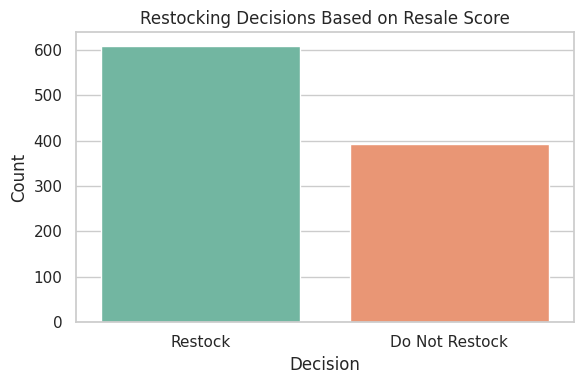

In [35]:
#plot
plt.figure(figsize=(6,4))
sns.countplot(x='restock_decision' , data=df , palette = 'Set2')
plt.title('Restocking Decisions Based on Resale Score')
plt.xlabel('Decision')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

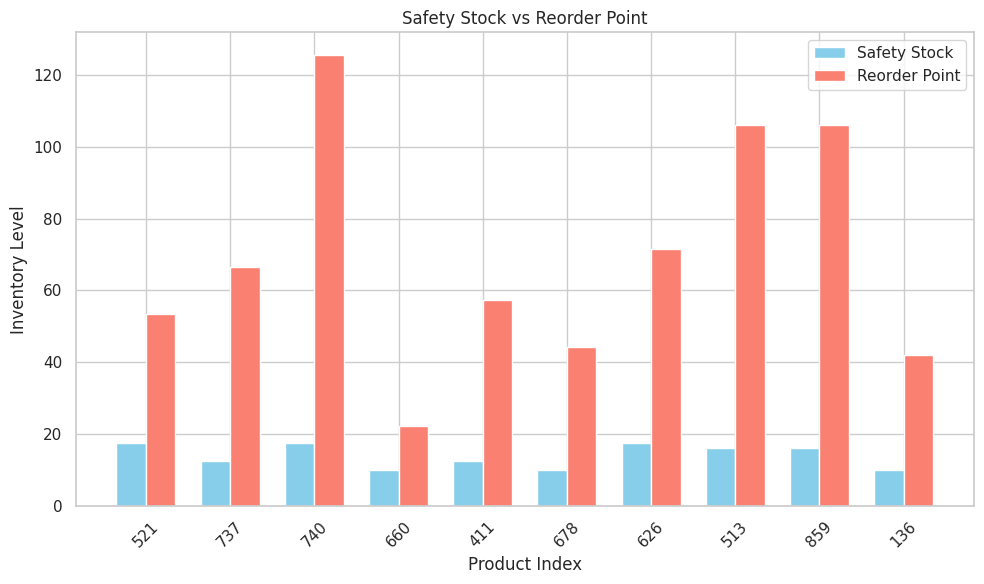

In [39]:
#visualize safety stock vs reorder point

#sample 10 rows for readability
sample_df = df.sample(10,random_state=42)

#plot
plt.figure(figsize=(10,6))
bar_width = 0.35
index = np.arange(len(sample_df))

#bars
plt.bar(index, sample_df['safety_stock'],bar_width ,label='Safety Stock' , color='skyblue')
plt.bar(index + bar_width , sample_df['reorder_point'] ,bar_width , label='Reorder Point' , color='salmon')

#plot
plt.xlabel('Product Index')
plt.ylabel('Inventory Level')
plt.title('Safety Stock vs Reorder Point')
plt.xticks(index + bar_width/2 , sample_df.index , rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Key Observations:

🔺 Reorder Point is always higher than Safety Stock — which is expected, since:

ROP
=
(
Avg Demand
×
Lead Time
)
+
Safety Stock
ROP=(Avg Demand×Lead Time)+Safety Stock

📈 Some products (e.g., product index 740, 513, 859) have very high reorder points, suggesting:

High daily demand or

Long lead time (or both)

⚖️ Safety stock values are relatively stable — since it's based on standard deviation of demand, not total demand.

📦 Products with low ROP (like 660, 678, 136) might be less critical or have faster restocking.

In [40]:
# Export inventory optimization data
inventory_df.to_csv('inventory_optimization_output.csv', index=False)
print("Inventory optimization results saved as 'inventory_optimization_output.csv'")


Inventory optimization results saved as 'inventory_optimization_output.csv'


This is useful for downstream systems or decision-making tools.